In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
np.random.seed(123)
random.seed(123)
H = 30
n = 600
sim = 1000

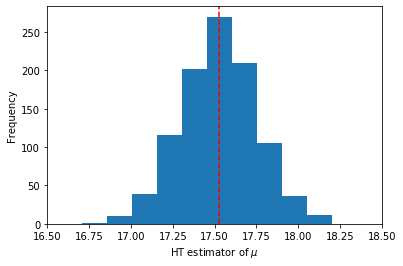

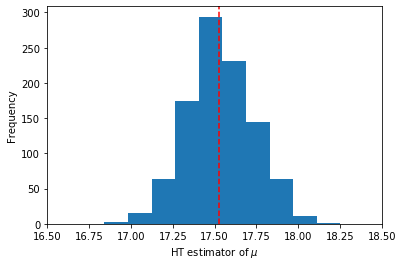

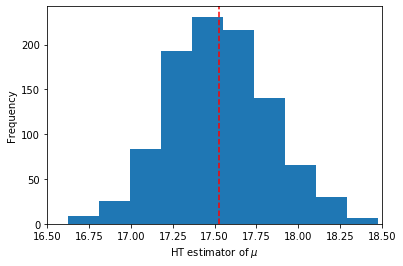

In [2]:
a_hs = np.random.uniform(low = 1, high = 10, size = H) #a_h~uniform(1,10)
N_hs = np.random.poisson(lam = 10 * a_hs) + 50 #生成每层的总体数
N = sum(N_hs)
max_N_h = max(N_hs) #最大层的总体数
Y = np.zeros([H, max_N_h])
for h in range(H):
    Y_h = 3 * a_hs[h] + np.random.normal(0, a_hs[h], size = N_hs[h])
    Y[h, :N_hs[h]] = Y_h 

S2_hs = []
for h in range(H):
    Y_h_nonzero = Y[h][:N_hs[h]] #因为前面定义Y的数组时，不够长的地方用0占了，筛选出非零数据用于计算方差
    S2_hs.append(np.var(Y_h_nonzero, ddof = 1))
S2_hs = np.array(S2_hs)
S_hs = np.sqrt(S2_hs)

#to make sum(n_h)==n
def adjust_n_hs(n_hs, n, according):
    rev_sorted_id = np.argsort(-according) #逆序排列返回索引值
    sorted_id = np.argsort(according) #正序排列返回索引值
    insert = 0 #insert表示插值次数
    while sum(n_hs) < n: #if 抽中的样本总数<n
        n_hs[rev_sorted_id[insert]] += 1
        insert += 1
    while sum(n_hs) > n: #if 抽中的样本总数>n
        n_hs[sorted_id[insert]] -= 1
        insert += 1
    return n_hs

#simple random sampling without replacement
def srs(n, N, y):
    srs_sample_index = np.random.choice(N, n, replace = False)
    srs_sample = y[srs_sample_index]
    srs_HT = np.mean(srs_sample)
    var_srs_HT = 1/n * (1-n/N) * np.var(srs_sample, ddof=1) #estimated variance of HT estimator
    return {'sample': srs_sample,
            'estimator': srs_HT, 
            'estimated variance': var_srs_HT}

#stratified simple random sampling without replacement
def stratified_srs(n_hs, N_hs, Y):
    N = sum(N_hs)
    H = len(N_hs)
    sample = []
    estimators = []
    est_variances = []  
    for h in range(H):
        sample.extend(list(srs(int(n_hs[h]), int(N_hs[h]), Y[h])['sample']))
        estimators.append(srs(int(n_hs[h]), int(N_hs[h]), Y[h])['estimator'])
        est_variances.append(srs(int(n_hs[h]), int(N_hs[h]), Y[h])['estimated variance'])
    estimators = np.array(estimators)
    est_variances = np.array(est_variances)
    return {'samples': sample,
            'estimators': estimators,
            'estimated variances': est_variances,
            'stratified estimator': sum(N_hs/N * estimators),
            'stratified variance': sum(N_hs**2 / N**2 * est_variances)}

#first scenario: 比例分配
k = n/N
n_hs = np.round(k * N_hs, 0) #比例分配是比例为n/N
n_hs = adjust_n_hs(n_hs, n, according = N_hs)

#second scenario: neyman分配
k2 = n / sum(N_hs * S_hs) #neyman分配的比例
n_hs2 = np.round(k2 * N_hs * S_hs, 0) #neyman分配
n_hs2 = adjust_n_hs(n_hs2, n, according = N_hs * S_hs)

#third scenario: 简单随机抽样
Y_onedim = Y.flatten()
Y_onedim = Y_onedim[Y_onedim != 0]
mu = np.mean(Y_onedim)

ESTs = np.zeros([sim, 3])
Variances = np.zeros([sim, 3])
for i in range(sim):
    ESTs[i, 0] = stratified_srs(n_hs, N_hs, Y)['stratified estimator']
    Variances[i, 0] = stratified_srs(n_hs, N_hs, Y)['stratified variance']
    ESTs[i, 1] = stratified_srs(n_hs2, N_hs, Y)['stratified estimator']
    Variances[i, 1] = stratified_srs(n_hs2, N_hs, Y)['stratified variance']
    ESTs[i, 2] = srs(n, N, Y_onedim)['estimator']
    Variances[i, 2] = srs(n, N, Y_onedim)['estimated variance']

for design in range(3):
    plt.plot()
    plt.hist(ESTs[:,design])
    plt.xlim(16.5, 18.5)
    plt.axvline(x = mu, linestyle = '--', color = 'r')
    plt.xlabel(r'HT estimator of $\mu$')
    plt.ylabel('Frequency')
    plt.savefig('mu_design_' + str(design+1) + '.png')
    plt.show()
    plt.close()


In [6]:
V_stratified_srs1 = 1/N**2 * sum(N_hs**2/n_hs * (1-n_hs/N_hs) * S2_hs)
V_stratified_srs2 = 1/N**2 * sum(N_hs**2/n_hs2 * (1-n_hs2/N_hs) * S2_hs)
V_srs = 1/n * (1-n/N) * np.var(Y_onedim, ddof = 1)
true_V = np.array([V_stratified_srs, V_stratified_srs2, V_srs])
print(r'Monte Carlo bias of $\hat{\mu}$ is', np.round(ESTs.mean(axis = 0)-mu,4))
print('V is', np.round(true_V, 4))
print(r'average $\hat{V}$ is', np.round(Variances.mean(axis = 0), 4))

Monte Carlo bias of $\hat{\mu}$ is [-0.0045  0.0066 -0.0041]
V is [0.0497 0.0426 0.0957]
average $\hat{V}$ is [0.0497 0.0426 0.0958]


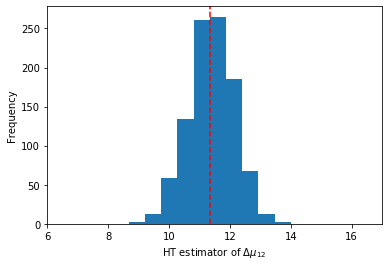

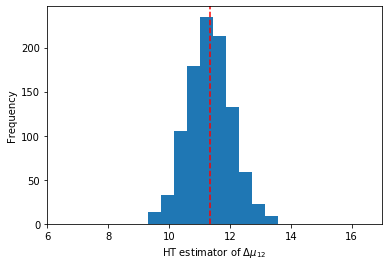

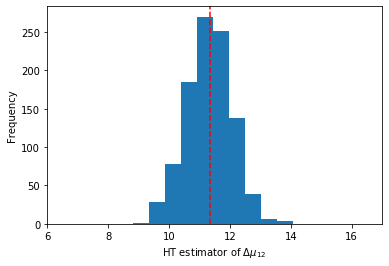

Monte Carlo bias of $\hat{\Delta \mu_{12}}$ is [ 0.0446 -0.0034 -0.0172]


In [4]:
#the optimal allocation of first two sample size
n0 = 100
N0 = sum(N_hs[:2])

#first scenario: 比例分配
new_k = n0/N0
new_n_hs = np.round(new_k * N_hs[:2], 0) #比例分配是比例为n/N
new_n_hs = adjust_n_hs(new_n_hs, n0, according = N_hs[:2])

#second scenario: neyman分配
new_k2 = n0 / sum(N_hs[:2] * S_hs[:2]) #neyman分配的比例
new_n_hs2 = np.round(new_k2 * N_hs[:2] * S_hs[:2], 0) #neyman分配
new_n_hs2 = adjust_n_hs(new_n_hs2, n0, according = N_hs[:2] * S_hs[:2])

#n_h is propotional to S_h, the propotion is n_0/sum(S_h)
k3 = n0 / sum(S_hs[:2])
n_hs3 = np.round(k3 * S_hs[:2], 0) #分配
n_hs3 = adjust_n_hs(n_hs3, n0, according = S_hs[:2])

results = np.zeros([sim, 9])
for i in range(sim):
    results[i,:2] = stratified_srs(new_n_hs, N_hs[:2], Y[:2])['estimators']
    results[i,2:4] = stratified_srs(new_n_hs2, N_hs[:2], Y[:2])['estimators']
    results[i,4:6] = stratified_srs(n_hs3, N_hs[:2], Y[:2])['estimators']
results[:,6] = results[:,0] - results[:,1]
results[:,7] = results[:,2] - results[:,3]
results[:,8] = results[:,4] - results[:,5]

Y0_delete0 = Y[0][Y[0] != 0]
Y1_delete0 = Y[1][Y[1] != 0]
true_delta = np.mean(Y0_delete0) - np.mean(Y1_delete0)

for design in range(3):
    plt.plot()
    plt.hist(results[:,design+6])
    plt.xlim(6, 17)
    plt.axvline(x = true_delta, linestyle = '--', color = 'r')
    plt.xlabel(r'HT estimator of $\Delta \mu_{12}$')
    plt.ylabel('Frequency')
    plt.savefig('Delta_design_' + str(design+1) + '.png')
    plt.show()
    plt.close()
print(r'Monte Carlo bias of $\hat{\Delta \mu_{12}}$ is', np.round(results[:,6:9].mean(axis=0)-true_delta,4))

In [5]:
def var_delta(n_hs, N_hs, S2_hs):
    return sum(1/n_hs * (1-n_hs/N_hs) * S2_hs)
var1 = var_delta(new_n_hs, N_hs[:2], S2_hs[:2])
var2 = var_delta(new_n_hs2, N_hs[:2], S2_hs[:2])
var3 = var_delta(n_hs3, N_hs[:2], S2_hs[:2])
np.array([var1, var2, var3])

array([0.55429022, 0.51632572, 0.50199418])